In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Block, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo_fixed_3or4_layers import ODEOptimizationModel
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel_flexible
from pickle import pickle_data, unpickle_data

ImportError: cannot import name 'pickle_data' from 'pickle' (/Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/pickle.py)

In [2]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [3]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 10, 10, 2], penalty_lambda = 1000, max_iter = 200)
ode_model.build_model()
ode_model.solve_model(True)

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(t, u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

Ipopt 3.14.16: max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    51876
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    69234

Total number of variables............................:      372
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      198

In [7]:
print(ode_model.mae(y, u_model, v_model))
print(ode_model.mae(y, u_odeint, v_odeint))

0.15893423953213492
0.21643096218041524


In [34]:
"""pred = {
    't': t,
    'odeint_solution': solution,
    'u_model': u_model,
    'v_model': v_model,
    'y': y,
    'y_noisy': y_noisy
}

pickle_data(pred, 'harmonic_oscillator_pred_3_10_10_2.pkl')"""
data = unpickle_data('harmonic_oscillator_pred_3_10_10_2.pkl')

Data successfully unpickled from harmonic_oscillator_pred_3_10_10_2.pkl


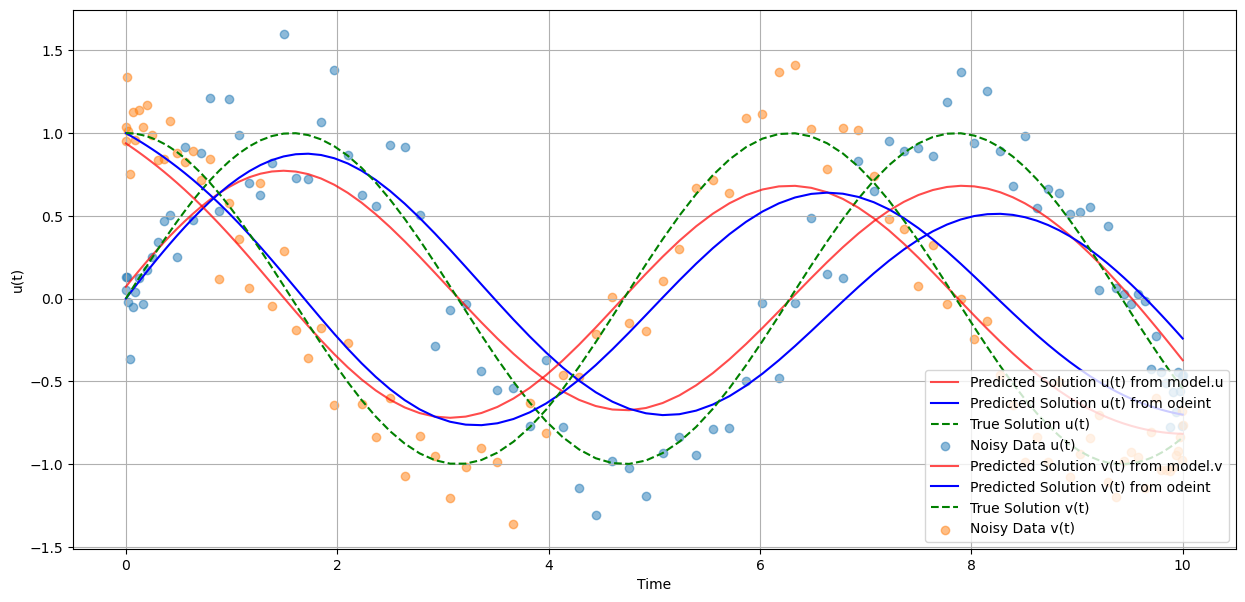

In [36]:
t_temp, odeint_solution_temp, u_model_temp, v_model_temp, y_noisy_temp, y_temp = data["t"], data["odeint_solution"], data["u_model"], data["v_model"], data["y_noisy"], data["y"]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_temp, u_model_temp, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_temp, odeint_solution_temp.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_temp, y_temp.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t_temp, y_noisy_temp.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_temp, v_model_temp, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_temp, odeint_solution_temp.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_temp, y_temp.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t_temp, y_noisy_temp.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [ ]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 100
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

In [45]:
ode_model = ODEOptimizationModel(y_noisy, t, D, [3, 50, 2], penalty_lambda = 1000, max_iter = 200)
ode_model.build_model()
ode_model.solve_model(True)

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    u, v = y
    du_dt, dv_dt = ode_model.predict(t, u, v)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
solution = odeint(system_dynamics, initial_conditions, t)
u_odeint, v_odeint = solution[:, 0], solution[:, 1]

Ipopt 3.14.16: max_iter=200


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    69696
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   123549

Total number of variables............................:      502
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      198

In [46]:
print(ode_model.mae(y, u_model, v_model))
print(ode_model.mae(y, u_odeint, v_odeint))

0.02330441517701901
0.027570027703505175


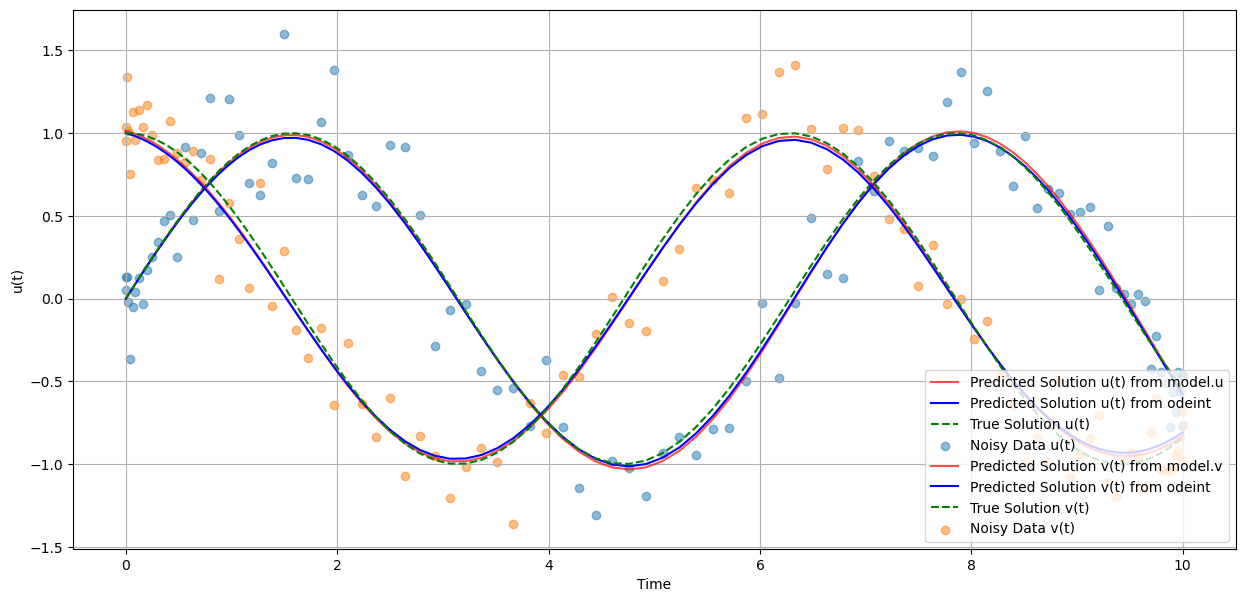

In [47]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t, solution.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t, solution.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t, y.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

#### Optimize `N of points` and `N of neurons in the hidden layer`

In [27]:
n_pts_li = [10, 25, 50, 100, 200, 500]
n_neurons_li = [5, 10, 25, 50, 100]

In [48]:
n_pts_li = [10, 25]
n_neurons_li = [5, 10]

In [52]:
results = {}
iter = 0

for n_pt in n_pts_li:
    
    # for each n_pts, generate data
    #---------------------------------------------DATA PARAMS---------------------------------------------#
    noise_level = 0.2
    ode_type, params = "harmonic_oscillator", {"omega_squared": 1}
    start_time, end_time = 0, 10
    spacing_type = "chebyshev"
    initial_state = jnp.array([0.0, 1.0])

    #--------------------------------------------GENERATE DATA--------------------------------------------#
    t, y, y_noisy, true_derivatives = generate_ode_data(n_pt, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

    # numpy array is required for pyomo
    y_noisy = np.array(jnp.squeeze(y_noisy))
    t = np.array(jnp.squeeze(t))

    #---------------------------COLLOCATION MATRIX PREPARATION--------------------------#
    weights = compute_weights(t)
    D = np.array(lagrange_derivative(t, weights))
    
    for n_neurons in n_neurons_li:

        #---------------------------------MODEL---------------------------------#
        ode_model = ODEOptimizationModel(y_noisy, t, D, [3, n_neurons, 2], penalty_lambda = 1000, max_iter = 500)
        ode_model.build_model()
        ode_model.solve_model(True)

        u_model, v_model = ode_model.extract_solution()

        def system_dynamics(y, t):
            u, v = y
            du_dt, dv_dt = ode_model.predict(t, u, v)
            return jnp.array([du_dt, dv_dt])

        initial_conditions = jnp.array([0.0, 1.0]) 
        solution = odeint(system_dynamics, initial_conditions, t)
        u_odeint, v_odeint = solution[:, 0], solution[:, 1]

        #---------------------------MEAN ABSOLUTE ERROR--------------------------#
        mae_model = ode_model.mae(y, u_model, v_model)
        mae_odeint = ode_model.mae(y, u_odeint, v_odeint)
        
        # save results
        results[str(n_pt) + "_" + str(n_neurons)] = {
            "t":t, "y":y, "y_noisy":y_noisy, 
            "mae_model":mae_model, "mae_odeint":mae_odeint, 
            "u_model":u_model, "v_model":v_model, 
            "u_odeint":u_odeint, "v_odeint":v_odeint,
            "solution":solution,
            "n_pts":n_pt, "n_neurons":n_neurons
            }

Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1329

Total number of variables............................:       52
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18

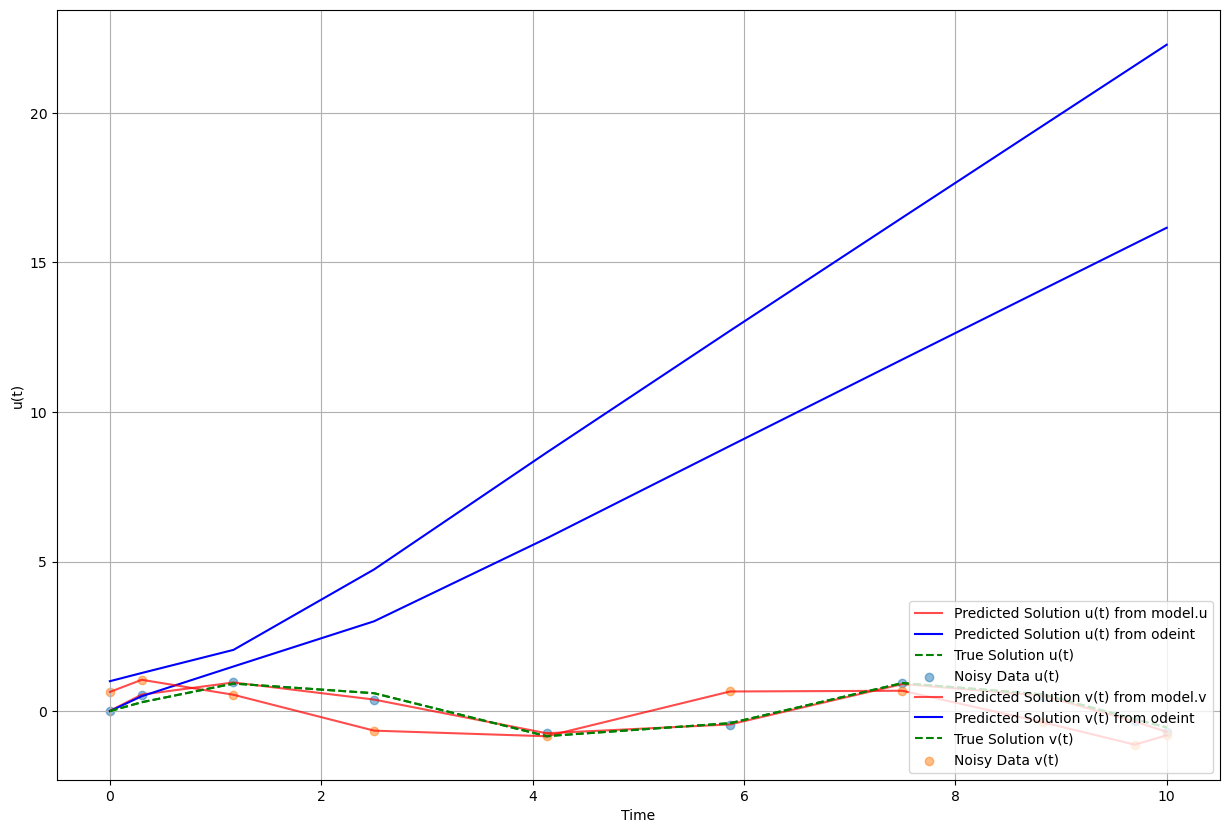

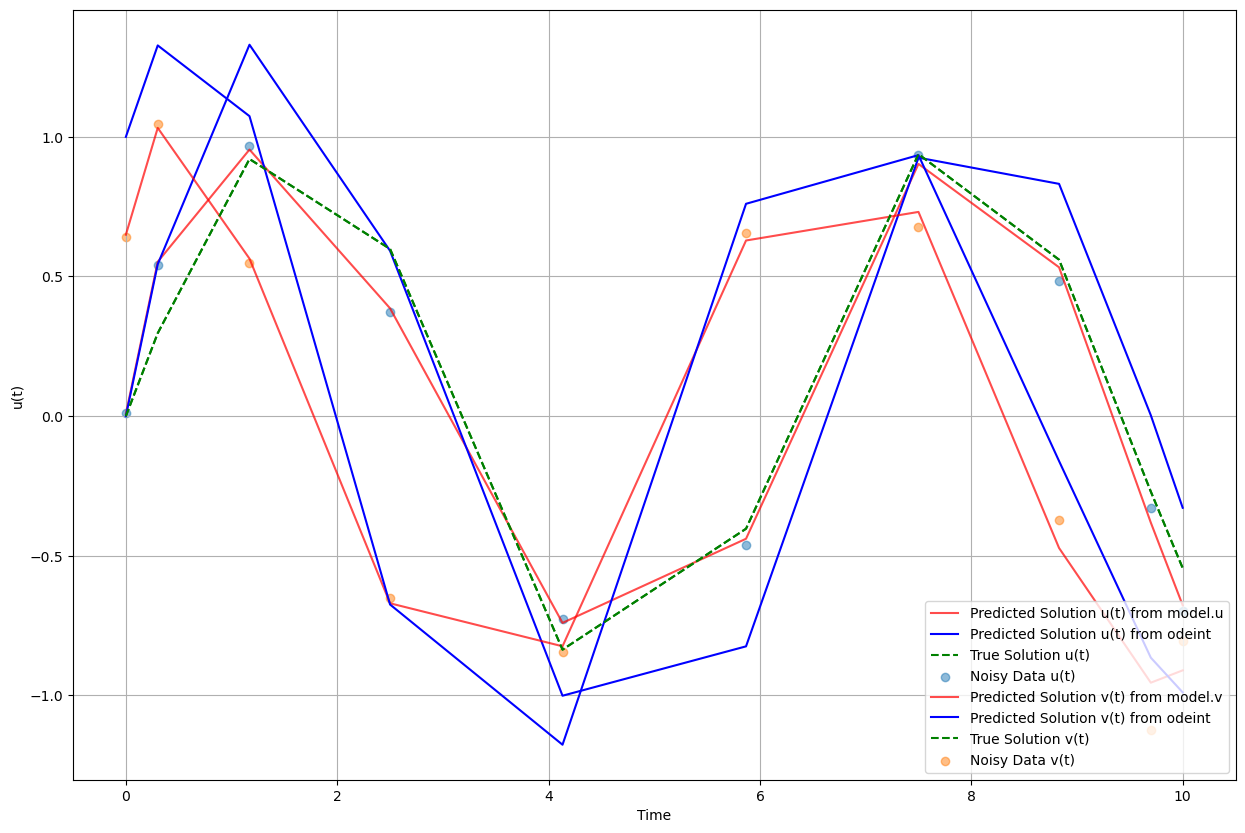

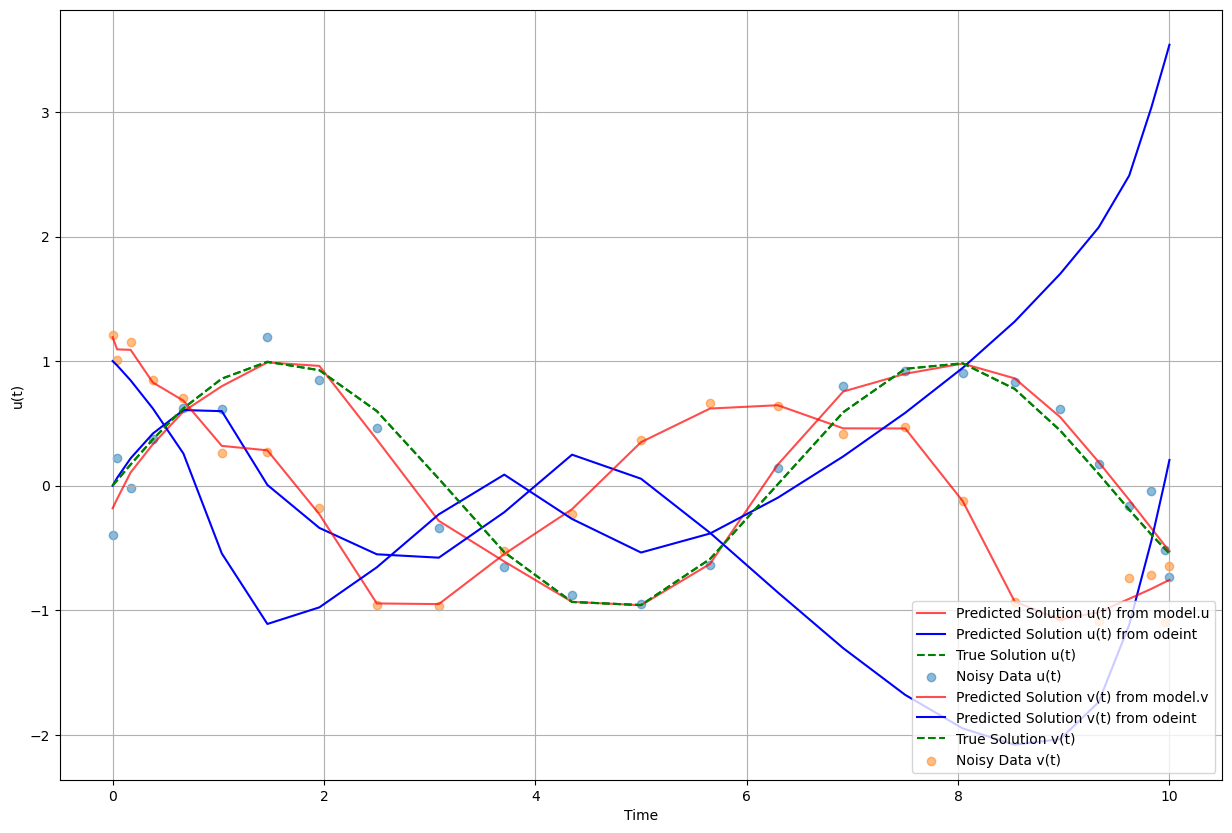

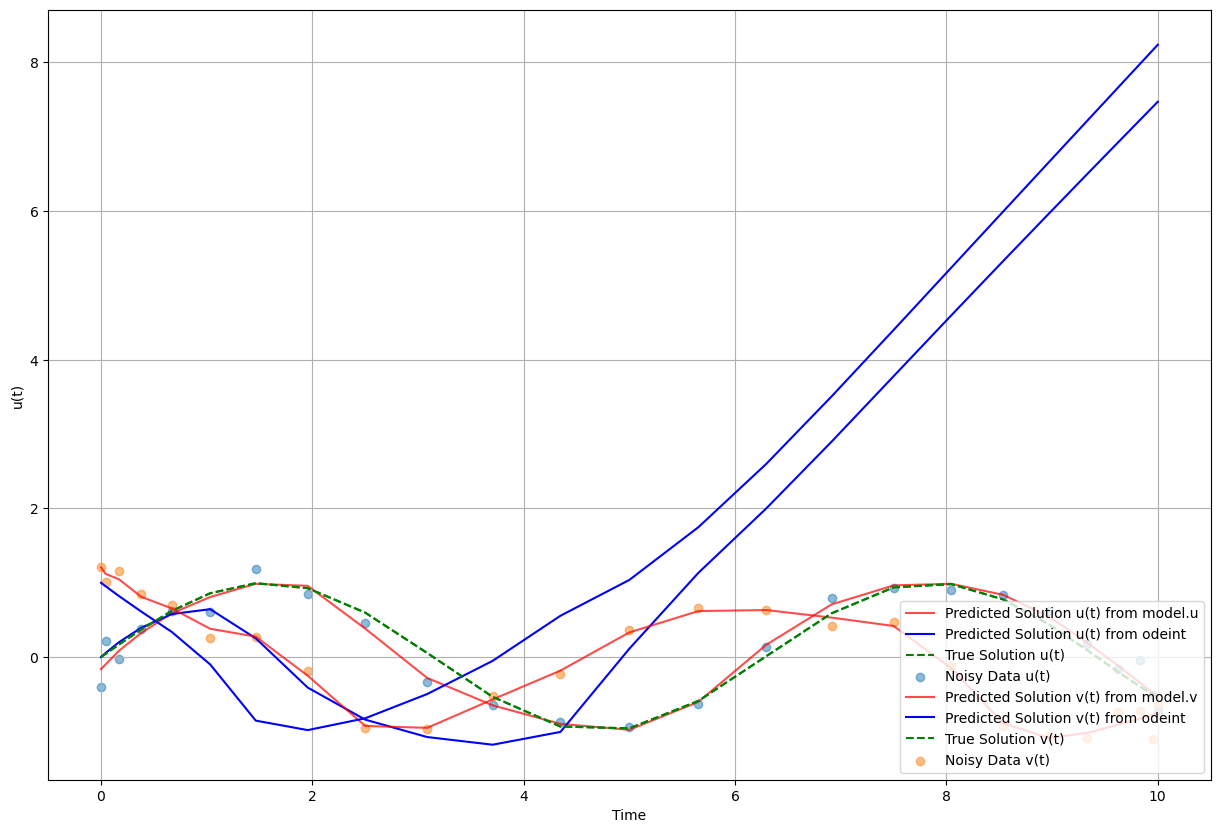

In [56]:
for n_pt in n_pts_li:
    for n_neurons in n_neurons_li:
        result = results[str(n_pt) + "_" + str(n_neurons)]
        t, y, y_noisy = result["t"], result["y"], result["y_noisy"]
        mae_model, mae_odeint = round(mae_model, 4), round(mae_odeint, 4)
        u_model, v_model, u_odeint, v_odeint = result["u_model"], result["v_model"], result["u_odeint"], result["v_odeint"]
        plt.figure(figsize=(15, 10))
        plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
        plt.plot(t, u_odeint, 'b', label='Predicted Solution u(t) from odeint')
        plt.plot(t, y.T[0], 'g--', label='True Solution u(t)')
        plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

        plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
        plt.plot(t, v_odeint, 'b', label='Predicted Solution v(t) from odeint')
        plt.plot(t, y.T[0], 'g--', label='True Solution v(t)')
        plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)
        plt.xlabel('Time')
        plt.ylabel('u(t)')
        plt.legend(loc ="lower right")
        plt.grid(True)
        plt.show()